# Cluster

## Paso 1.Cargar las librerias de trabajo

Se importan todas las librerías necesarias para la manipulación de datos, el preprocesamiento, la implementación de K-Means, el cálculo del Silhouette Score, la reducción de dimensionalidad (PCA) y el clustering jerárquico.

In [18]:
# Importar Librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
print("Librerías cargadas.")

Librerías cargadas.


## Paso 2. Carga de Archivo

Se carga el archivo de datos de la flota de buses (flota_vinculada_20250916_limpio.xlsx) en un DataFrame de pandas para su posterior análisis.

In [21]:

# Carga de Archivo (Solución Definitiva para XLSX)

file_path = r'C:\Users\Sebastian\OneDrive\Escritorio\cluster\flota_vinculada_20250916_limpio.xlsx' 
try:
    # Usamos read_excel en lugar de read_csv
    df = pd.read_excel(file_path)
    
    # Si el archivo tiene la estructura de CSV pero está en Excel,
    # verificamos si la primera columna es 'Fecha_matricula'
    if df.columns[0] != 'Fecha_matricula':
        print("Advertencia: Las columnas parecen estar unidas. Revisar el archivo Excel.")
        
except FileNotFoundError:
    print(f"ERROR: Archivo no encontrado en la ruta: {file_path}")
    print("Por favor, verifica la ruta de nuevo.")
except Exception as e:
    print(f"Error inesperado al cargar el archivo: {e}")
    
print(f"Datos cargados: {df.shape[0]} filas.")
print("Columnas cargadas:")
print(df.columns.tolist())
df.head()

Datos cargados: 10493 filas.
Columnas cargadas:
['Fecha_matricula', 'Concesionario_operacion', 'Concesionario_provision', 'Zona', 'Fase', 'Componente', 'Estatus_vinculacion', 'Combustible', 'Modelo', 'Codigo_bus', 'Fecha_vinculacion', 'Accesible', 'Edad', 'Matricula', 'Descripcion_estado_vinculacion', 'Descripcion_nivel_emision', 'Descripcion_tipo', 'Estado']


,Fecha_matricula,Concesionario_operacion,Concesionario_provision,Zona,Fase,Componente,Estatus_vinculacion,Combustible,Modelo,Codigo_bus,Fecha_vinculacion,Accesible,Edad,Matricula,Descripcion_estado_vinculacion,Descripcion_nivel_emision,Descripcion_tipo,Estado
0,2020-02-03,CAPITALBUS S.A.S,MASIVO BOGOT S.A.S,AMERICAS,FASE IV,TRONCAL,Referente,GNV,2020,K1411,2020-02-28,PLATAFORMA ALTA,5,GUW531,Vinculado,EURO VI,BIARTICULADO,Buen estado
1,2020-02-03,CAPITALBUS S.A.S,MASIVO BOGOT S.A.S,AMERICAS,FASE IV,TRONCAL,Referente,GNV,2020,K1414,2020-02-28,PLATAFORMA ALTA,5,GUW534,Vinculado,EURO VI,BIARTICULADO,Buen estado
2,2020-02-03,CAPITALBUS S.A.S,MASIVO BOGOT S.A.S,AMERICAS,FASE IV,TRONCAL,Referente,GNV,2020,K1469,2020-02-28,PLATAFORMA ALTA,5,GUW589,Vinculado,EURO VI,BIARTICULADO,Buen estado
3,2020-02-03,CAPITALBUS S.A.S,MASIVO BOGOT S.A.S,AMERICAS,FASE IV,TRONCAL,Referente,GNV,2020,K1403,2020-02-28,PLATAFORMA ALTA,5,GUW523,Vinculado,EURO VI,BIARTICULADO,Buen estado
4,2020-02-03,CAPITALBUS S.A.S,MASIVO BOGOT S.A.S,AMERICAS,FASE IV,TRONCAL,Referente,GNV,2020,K1484,2020-02-28,PLATAFORMA ALTA,5,GUW604,Vinculado,EURO VI,BIARTICULADO,Buen estado


# Paso 3. Ingeniería de Características (Antigüedad en Días)


Se convierten las columnas de fecha a formato datetime y se calcula la antigüedad de la matrícula y el tiempo de vinculación en días con respecto a una fecha base (2025-11-12).

In [23]:
# Ingeniería de Características 

# Convertir las columnas de fecha a formato datetime
# Se agrega 'dayfirst=True' por si el formato es día/mes/año
df['Fecha_matricula'] = pd.to_datetime(df['Fecha_matricula'], errors='coerce', dayfirst=True)
df['Fecha_vinculacion'] = pd.to_datetime(df['Fecha_vinculacion'], errors='coerce', dayfirst=True)
    
# Definir una fecha base
fecha_base = pd.to_datetime('2025-11-12') 
    
# Calcular la antigüedad en días para usarla como variable numérica precisa
df['Antiguedad_Matricula_Dias'] = (fecha_base - df['Fecha_matricula']).dt.days
df['Tiempo_Vinculacion_Dias'] = (fecha_base - df['Fecha_vinculacion']).dt.days
    
print("Nuevas variables numéricas de tiempo creadas.")

Nuevas variables numéricas de tiempo creadas.


# Paso 4. Selección y Preparación de Dataset de Trabajo

Se seleccionan las características para el clustering (Antiguedad_Matricula_Dias, Tiempo_Vinculacion_Dias, Descripcion_nivel_emision) y se realiza la imputación de valores nulos, usando la mediana para las variables numéricas y la moda para la categórica.

In [25]:

# Selección y Preparación de Dataset de Trabajo

# Variables a usar: las nuevas numéricas y la categórica de Emisión
FEATURES = ['Antiguedad_Matricula_Dias', 'Tiempo_Vinculacion_Dias', 'Descripcion_nivel_emision']
df_work = df[FEATURES].copy()

# Imputación de Nulos (Necesario para el clustering)
for col in ['Antiguedad_Matricula_Dias', 'Tiempo_Vinculacion_Dias']:
    df_work[col].fillna(df_work[col].median(), inplace=True)

if 'Descripcion_nivel_emision' in df_work.columns:
    # Si hay nulos en la categoría, imputamos con la moda (valor más frecuente)
    df_work['Descripcion_nivel_emision'].fillna(df_work['Descripcion_nivel_emision'].mode()[0], inplace=True)
    
print("Valores nulos después de imputación:")
print(df_work.isnull().sum())

Valores nulos después de imputación:
Antiguedad_Matricula_Dias    0
Tiempo_Vinculacion_Dias      0
Descripcion_nivel_emision    0
dtype: int64


# Paso 5. Pipeline de Preprocesamiento

Se define un Pipeline para aplicar StandardScaler (estandarización) a las variables numéricas y OneHotEncoder (codificación one-hot) a la variable categórica de nivel de emisión.

In [26]:

# Pipeline de Preprocesamiento

numerical_features = ['Antiguedad_Matricula_Dias', 'Tiempo_Vinculacion_Dias']
categorical_features = ['Descripcion_nivel_emision']

preprocessor = ColumnTransformer(
    transformers=[
        # Estandariza (StandardScaler) los valores numéricos altos (días)
        ('num', StandardScaler(), numerical_features),
        # Codificación One-Hot para variables categóricas
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop' 
)

X_processed = preprocessor.fit_transform(df_work)

print(f"Número final de características (columnas) para el clustering: {X_processed.shape[1]}")

Número final de características (columnas) para el clustering: 9


# Paso 6. Determinación de K y Visualización

Se utiliza el Silhouette Score para determinar el número óptimo de clústeres (K) para el algoritmo K-Means, iterando desde $K=2$ hasta $K=10$ y graficando los resultados.

K Sugerido (Máximo Silhouette Score): 9


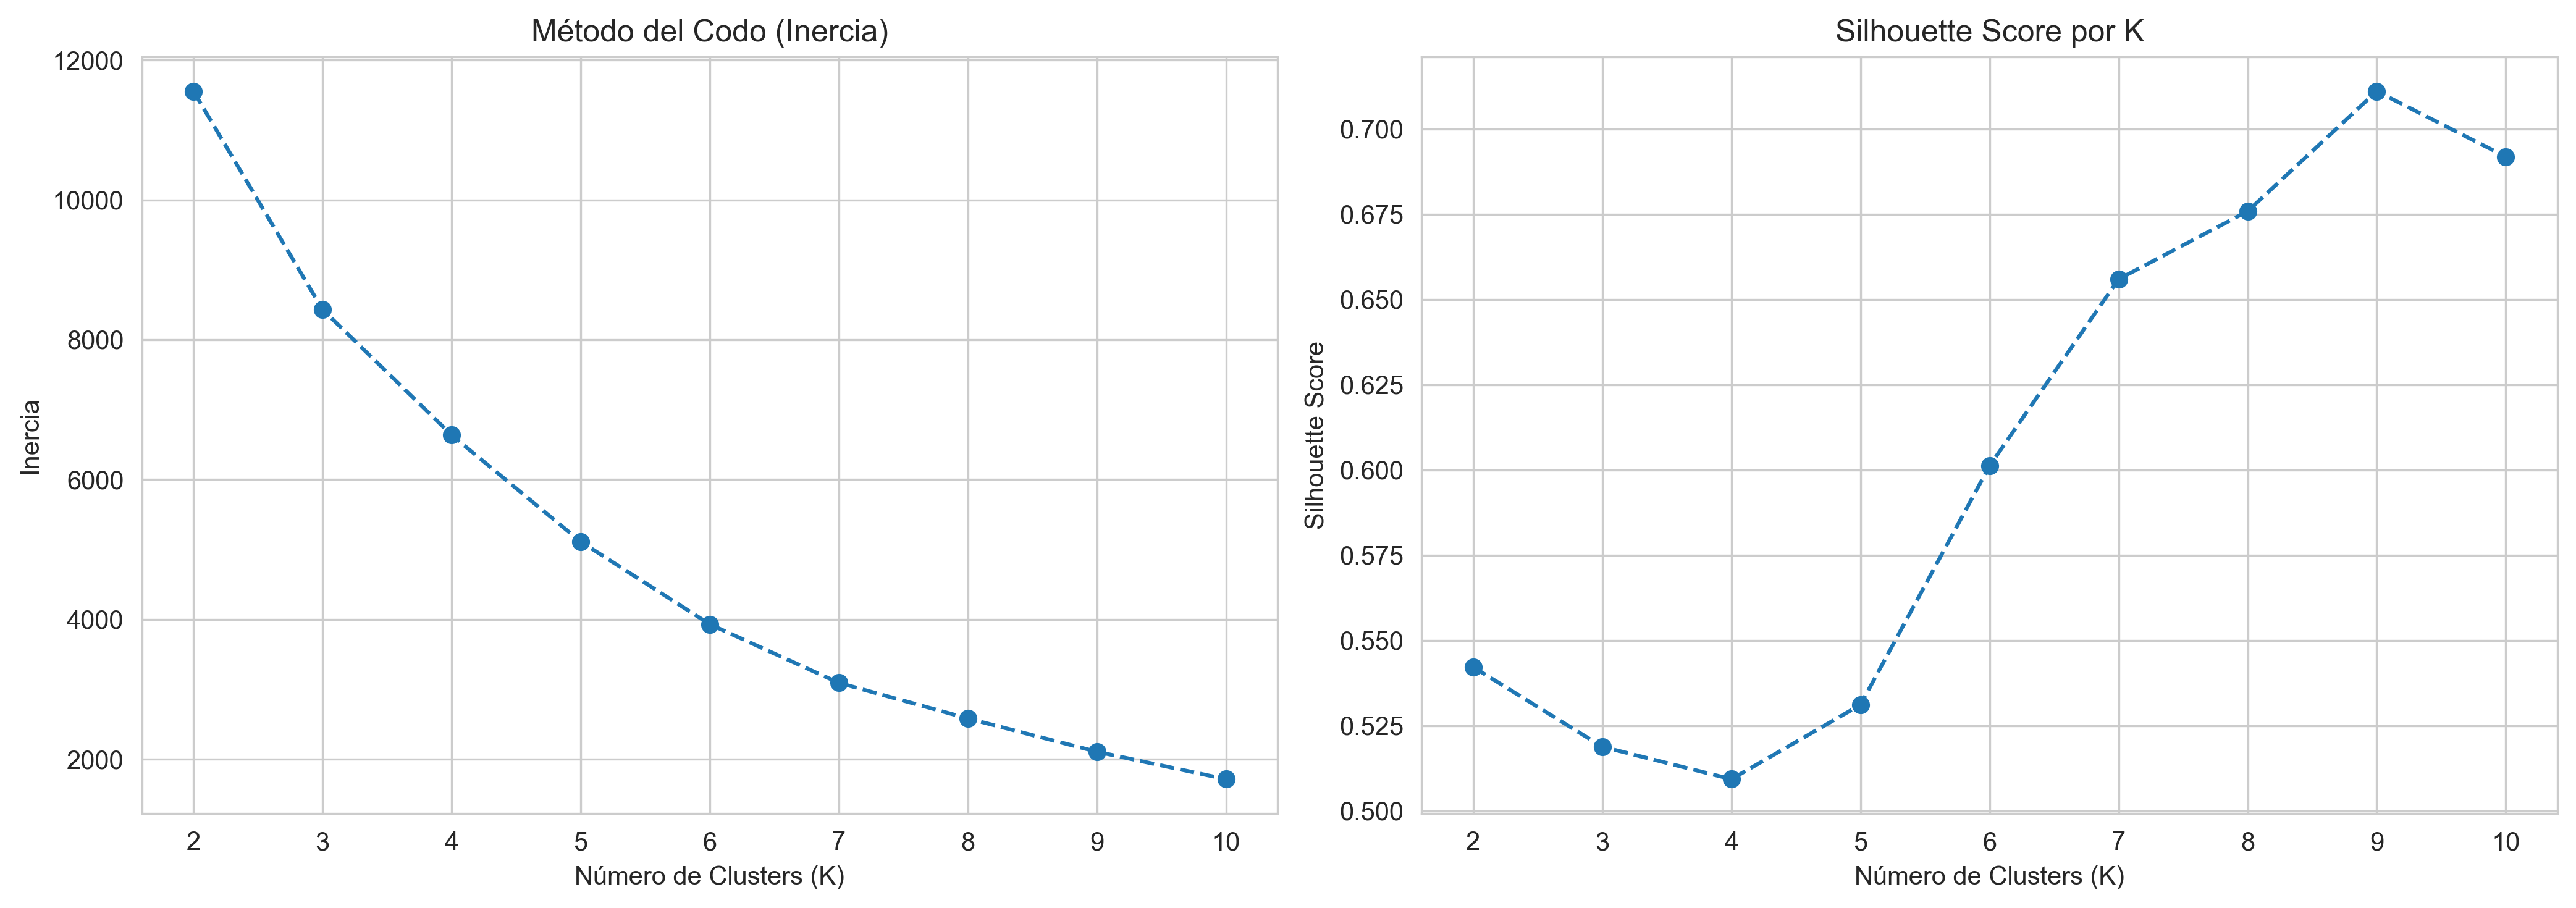

In [28]:
# Determinación de K y Visualización

# Método del Codo (Elbow Method) y Silhouette Score
max_k = 10
inertia = []
silhouette_scores = []
K_range = range(2, max_k + 1)

# Evaluar K desde 2 hasta max_k
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)
    
    if k >= 2:
        score = silhouette_score(X_processed, kmeans.labels_)
        silhouette_scores.append(score)
        
# Sugerir K basado en el mejor Silhouette Score
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)] if silhouette_scores else 3

print(f"K Sugerido (Máximo Silhouette Score): {optimal_k_silhouette}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Método del Codo (Elbow Method) - Sin cambios
axes[0].plot(K_range, inertia, marker='o', linestyle='--')
axes[0].set_title('Método del Codo (Inercia)')
axes[0].set_xlabel('Número de Clusters (K)')
axes[0].set_ylabel('Inercia')

# Silhouette Score 
# K_range contiene K=2, 3, 4, ..., 10.
axes[1].plot(K_range, silhouette_scores, marker='o', linestyle='--')
axes[1].set_title('Silhouette Score por K')
axes[1].set_xlabel('Número de Clusters (K)')
axes[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Paso 7. Ejecución Final de K-Means

Se aplica el algoritmo K-Means con el número óptimo de clústeres ($K=9$) y se asigna el resultado al DataFrame original.

In [29]:
# Ejecución Final de K-Means

optimal_k = optimal_k_silhouette 

print(f"[Aplicando K-Means con K={optimal_k}]")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_work['Cluster_KMeans'] = kmeans.fit_predict(X_processed)

# Añadir la columna original 'Estado' para el análisis final
df_final = df_work.copy()
if 'Estado' in df.columns:
    df_final['Estado'] = df['Estado'] 

print("Distribución de observaciones por Cluster:")
print(df_final['Cluster_KMeans'].value_counts().sort_index())

[Aplicando K-Means con K=9]
Distribución de observaciones por Cluster:
Cluster_KMeans
0     334
1    2398
2    2728
3    1485
4     327
5    1031
6     701
7     592
8     897
Name: count, dtype: int64


# Paso 8. Perfilamiento de Clusters

Para poder visualizar el clustering en un plano 2D, se aplica el análisis de componentes principales (PCA) a los datos preprocesados (X_processed), reduciendo la dimensionalidad a dos componentes principales.

In [30]:
# Perfilamiento de Clusters

print("\nCaracterísticas promedio por Cluster (Perfilamiento):")

cluster_summary = df_final.groupby('Cluster_KMeans')[
    ['Antiguedad_Matricula_Dias', 'Tiempo_Vinculacion_Dias', 'Descripcion_nivel_emision']
].agg({
    'Antiguedad_Matricula_Dias': 'mean',
    'Tiempo_Vinculacion_Dias': 'mean',
    # Calculamos el 'Nivel de Emisión' más frecuente
    'Descripcion_nivel_emision': lambda x: x.mode()[0] if not x.mode().empty else 'N/A'
})

# Si la columna 'Estado' existe, la incluimos
if 'Estado' in df_final.columns:
     cluster_summary['Estado_Mas_Frecuente'] = df_final.groupby('Cluster_KMeans')['Estado'].apply(
         lambda x: x.mode()[0] if not x.mode().empty else 'N/A'
     )

print(cluster_summary.sort_values(by='Antiguedad_Matricula_Dias', ascending=False))


Características promedio por Cluster (Perfilamiento):
                Antiguedad_Matricula_Dias  Tiempo_Vinculacion_Dias  \
Cluster_KMeans                                                       
4                             5816.220183              2987.443425   
5                             4325.058196              4205.333657   
8                             4201.139353              1740.193980   
2                             4169.729472              4110.155425   
0                             4016.691617              3900.922156   
6                             2262.400856              2236.583452   
7                             1865.643581              1682.427365   
1                             1773.113428              1743.562969   
3                             1471.642424              1418.319192   

               Descripcion_nivel_emision Estado_Mas_Frecuente  
Cluster_KMeans                                                 
4                          (<) A EURO IV      

# Paso 9. Visualización con PCA

Se grafican los datos en el espacio de las dos componentes principales de PCA, coloreando cada punto según el clúster asignado por K-Means.

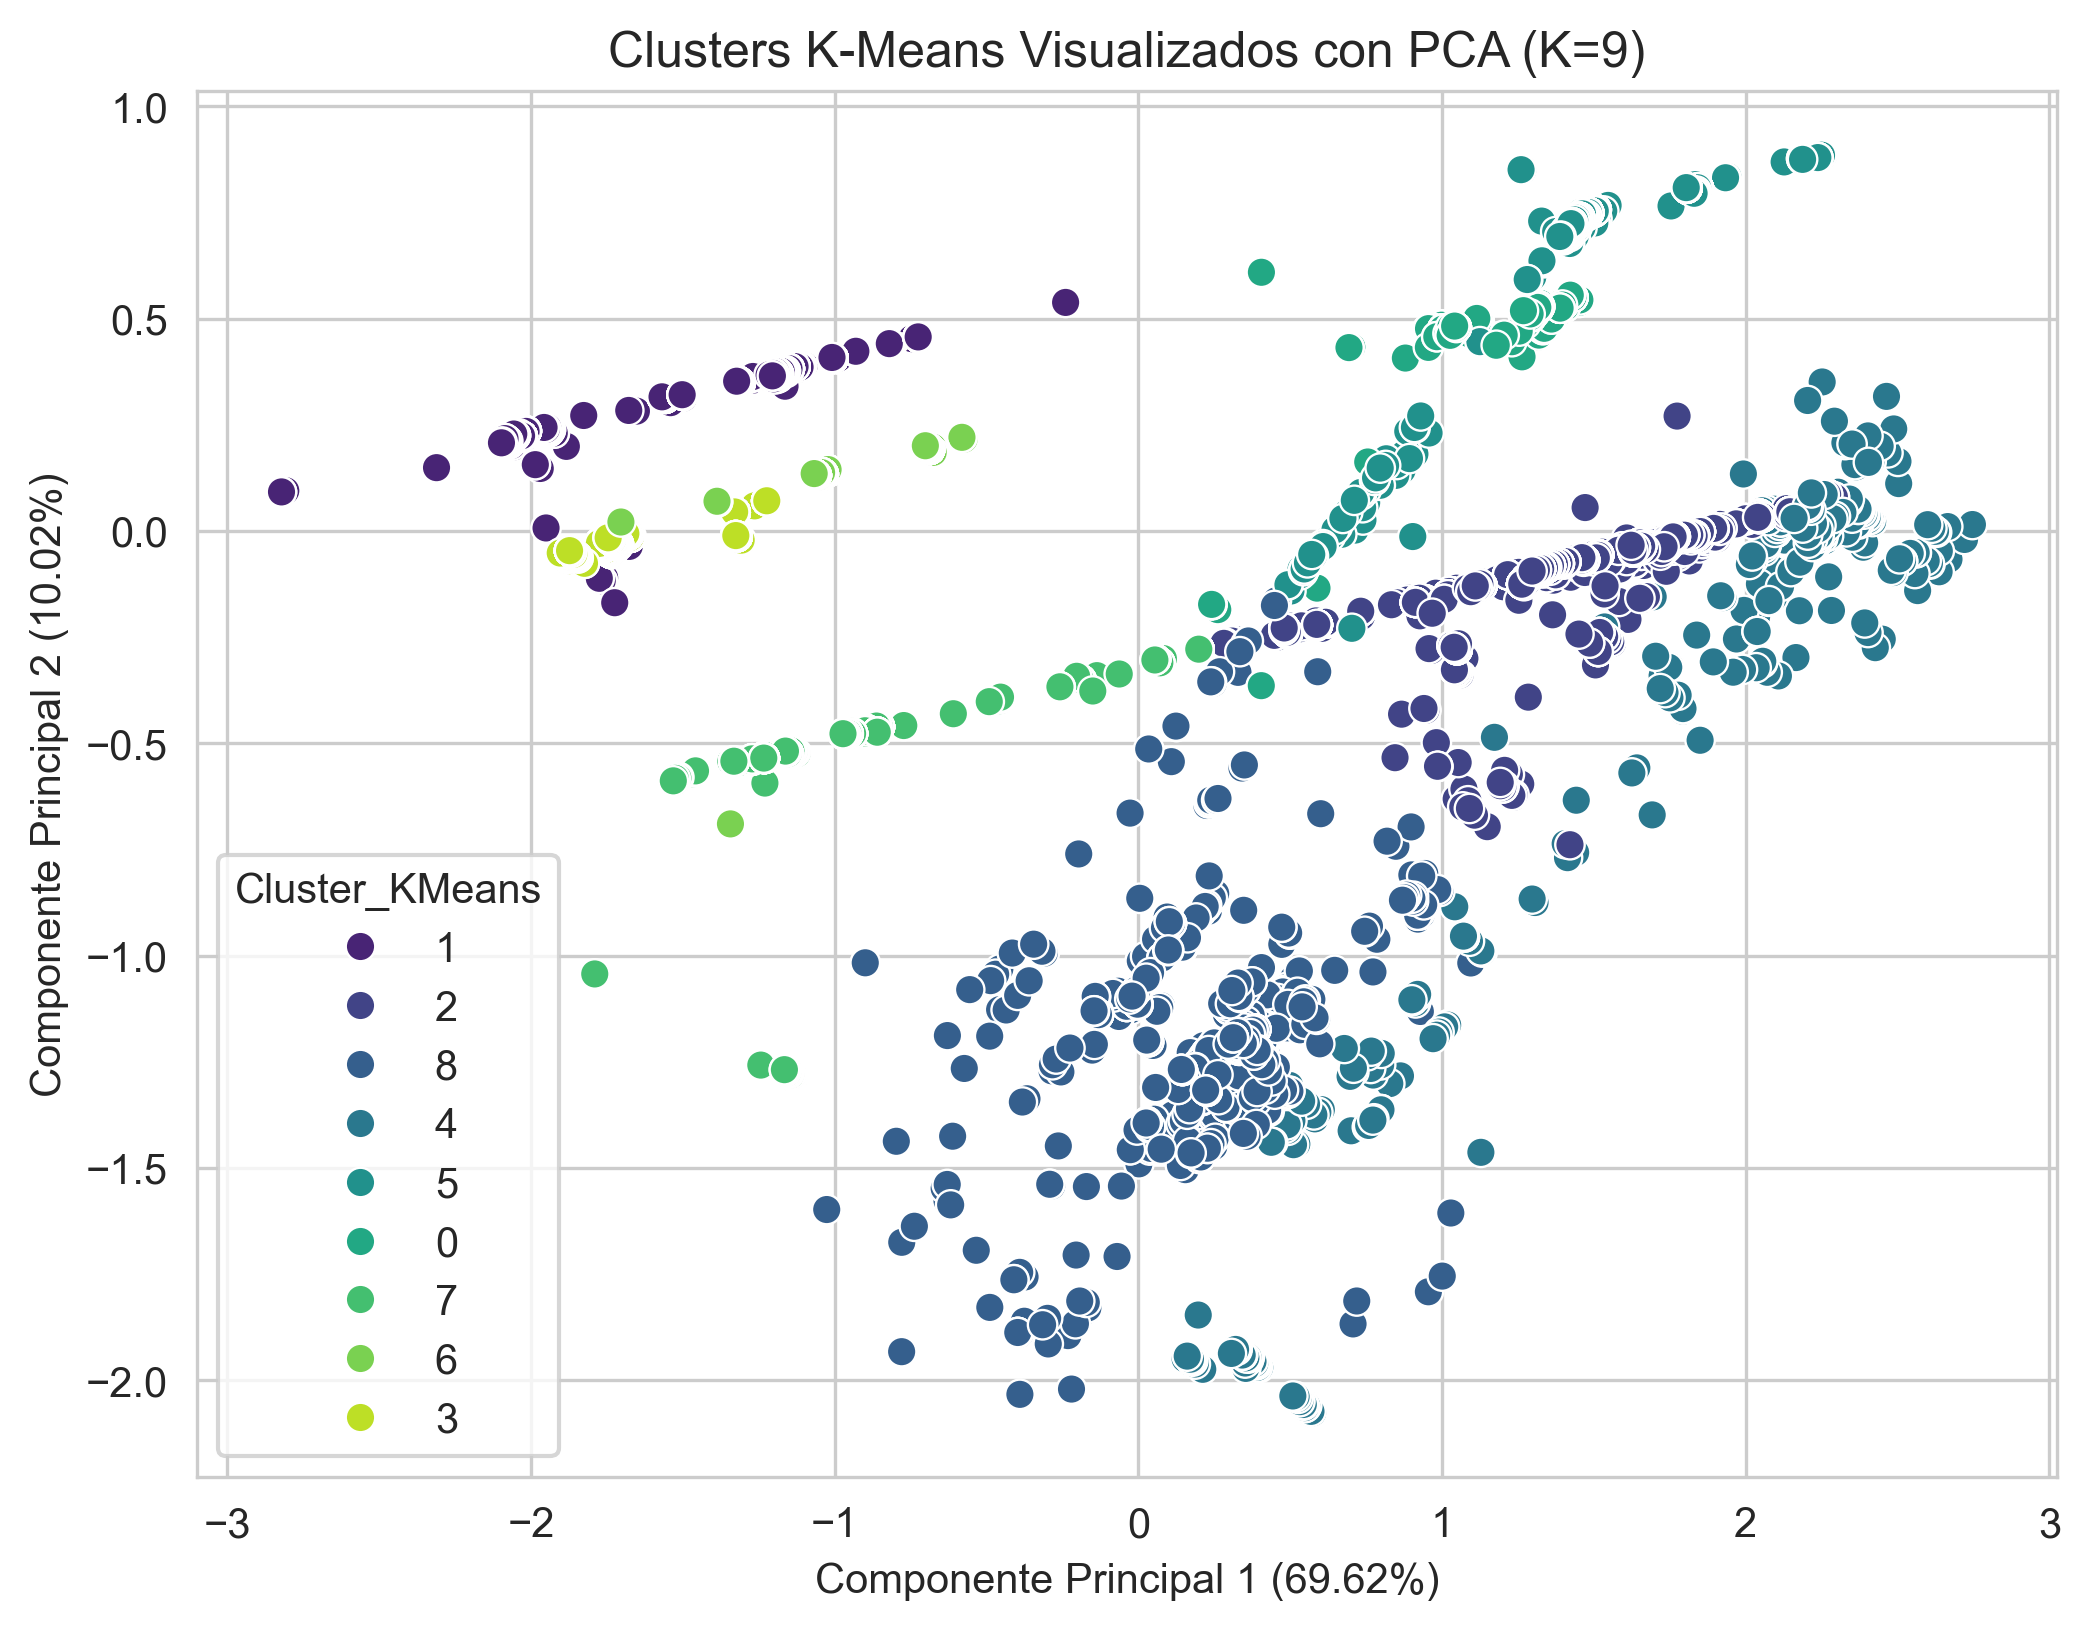

In [31]:
# Visualización con PCA

# PCA para reducir los datos a 2 dimensiones visualizables
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_processed)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster_KMeans'] = df_work['Cluster_KMeans'].astype(str).values 

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_KMeans', data=pca_df, palette='viridis', legend='full', s=50)
plt.title(f'Clusters K-Means Visualizados con PCA (K={optimal_k})')
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.show()

# Paso 10. Dendrograma (Clustering Jerárquico)

Se interpreta el resultado del clustering analizando el valor promedio de las variables numéricas clave (Antiguedad_Matricula_Dias) y la distribución de la variable categórica (Descripcion_nivel_emision) dentro de cada clúster.


In [1]:
# Dendrograma (Clustering Jerárquico)

plt.figure(figsize=(12, 6))
linkage_matrix = linkage(X_processed, method='ward')
dendrogram(linkage_matrix, 
    truncate_mode='lastp', 
    p=10, 
    show_leaf_counts=True,
    color_threshold=3.5) 
plt.title('Dendrograma del Clustering Jerárquico')
plt.xlabel('Observaciones o Clusters')
plt.ylabel('Distancia Euclidiana')
plt.show()

NameError: name 'plt' is not defined

# Paso 11. Importancia de las Características (Análisis de Centroides)

Se realiza un clustering jerárquico como método alternativo, y se visualiza el resultado mediante un dendrograma truncado.

Centroides (Valores Estandarizados) por Cluster:
Valores absolutos grandes indican mayor importancia para la formación del Cluster.
Cluster                                                       0             1  \
num__Antiguedad_Matricula_Dias                     7.183883e-01 -9.440111e-01   
num__Tiempo_Vinculacion_Dias                       9.588483e-01 -7.512909e-01   
cat__Descripcion_nivel_emision_(<) A EURO IV      -5.551115e-17  9.506285e-16   
cat__Descripcion_nivel_emision_CERO EMISIONES      4.996004e-16 -1.332268e-15   
cat__Descripcion_nivel_emision_EURO IV             1.110223e-16 -1.776357e-15   
cat__Descripcion_nivel_emision_EURO V             -4.440892e-16  6.883383e-15   
cat__Descripcion_nivel_emision_EURO V - ELECTRICO  9.910180e-01  7.285839e-16   
cat__Descripcion_nivel_emision_EURO V-CON FILTRO  -1.804112e-16  4.996004e-16   
cat__Descripcion_nivel_emision_EURO VI             8.982036e-03  1.000000e+00   

Cluster                                                  

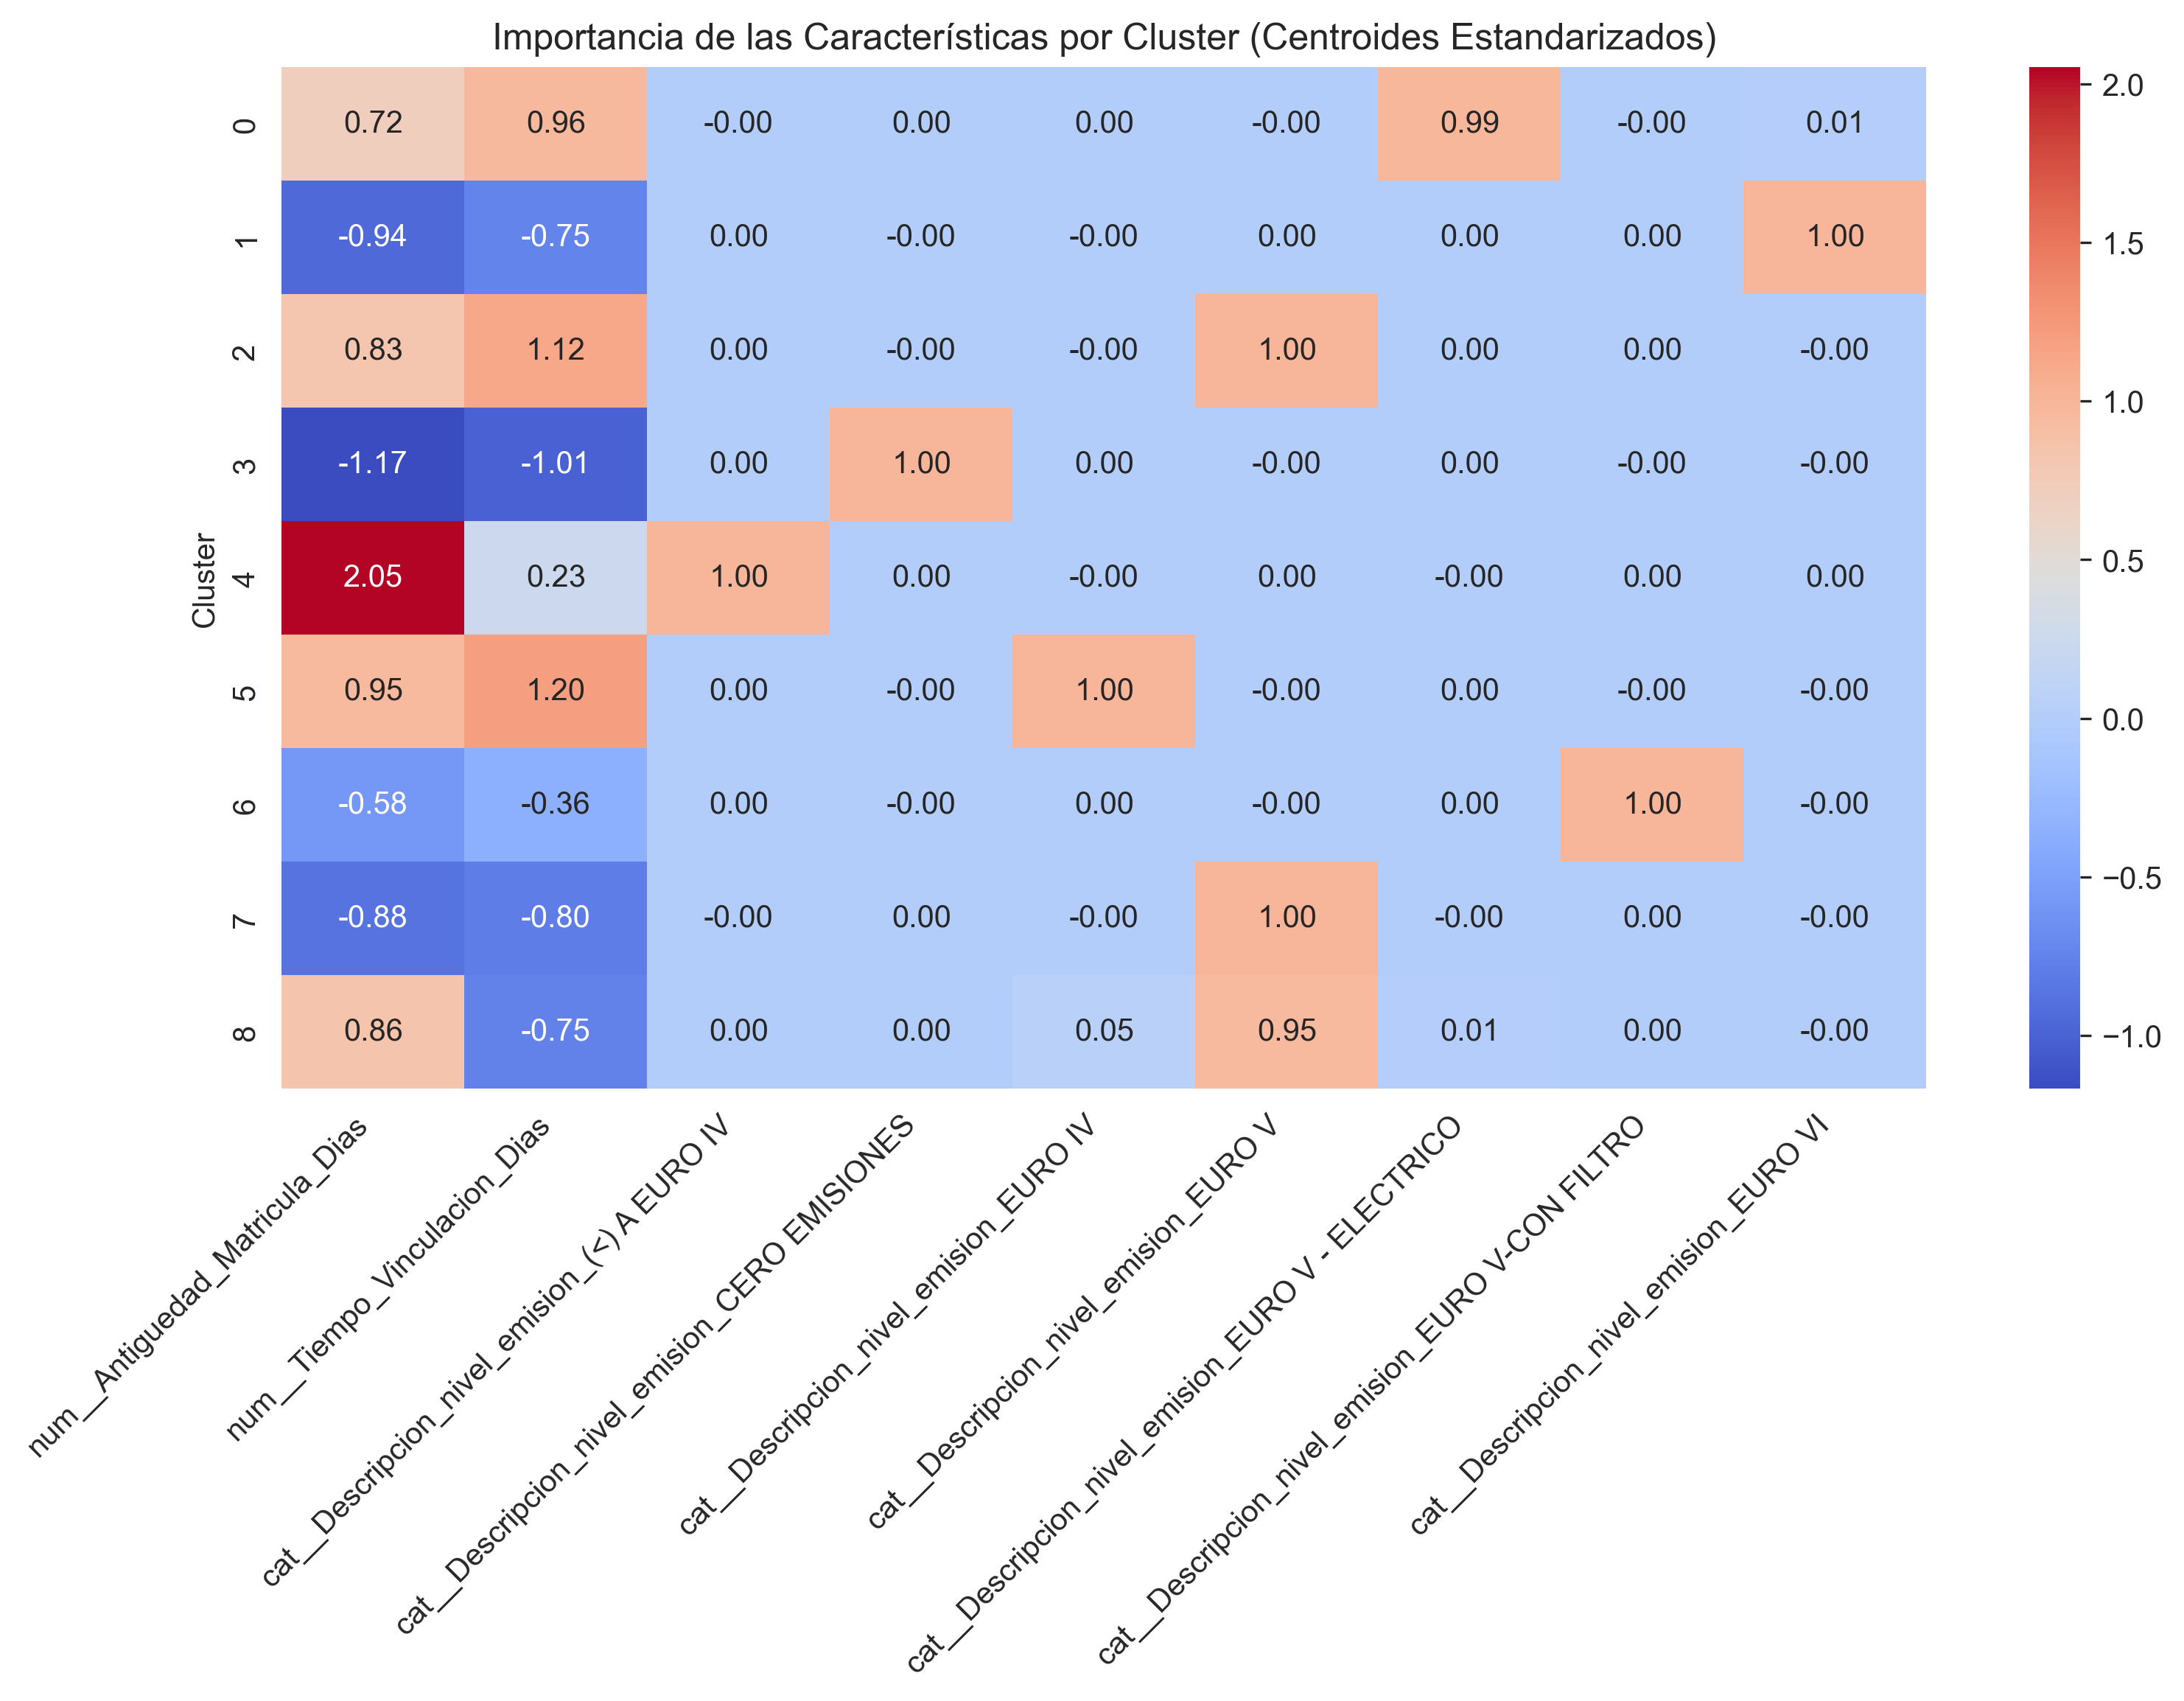

In [35]:
# Importancia de las Características (Análisis de Centroides)


# 1. Obtener los centroides del modelo K-Means
centroides_scaled = kmeans.cluster_centers_

# 2. Obtener los nombres de las columnas transformadas (incluyendo el OneHotEncoder)
feature_names = preprocessor.get_feature_names_out()

# 3. Crear un DataFrame de los centroides
df_centroides = pd.DataFrame(centroides_scaled, columns=feature_names)
df_centroides.index.name = 'Cluster'

print("Centroides (Valores Estandarizados) por Cluster:")
print("Valores absolutos grandes indican mayor importancia para la formación del Cluster.")
print(df_centroides.T) # Transponemos para mejor visualización (Clusters vs Features)

# 4. Visualización Gráfica
plt.figure(figsize=(12, 6))
sns.heatmap(df_centroides, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            yticklabels=df_centroides.index)
plt.title('Importancia de las Características por Cluster (Centroides Estandarizados)')
plt.ylabel('Cluster')
plt.xticks(rotation=45, ha='right')
plt.show()
#

# Concliciones

## Conclusión Final y Estratégica del Análisis de Clustering de Flota

El análisis de clustering no supervisado (K-Means) ha segmentado con éxito los **10,493 vehículos** de la flota en **nueve (9) grupos naturales y homogéneos**, lo cual permite una gestión de activos **diferenciada y estratégica**.

***

### I. Validación y Robustez del Modelo

La elección de **$K=9$** se valida como la estructura más precisa de la flota, según las métricas estadísticas y la visualización:

1.  **Justificación de K:** El **Silhouette Score** identificó $K=9$ como el número que ofrece el mejor equilibrio entre la **cohesión interna** de los grupos (vehículos similares dentro del clúster) y la **separación externa** (diferencia clara entre los clústeres).
2.  **Calidad Visual (PCA):** El gráfico de Componentes Principales (PCA)  confirma que los 9 clústeres son **visualmente distintos y densos**. La separación es particularmente notable entre los vehículos más nuevos y los más antiguos.
3.  **Validación Jerárquica (Dendrograma):** El Dendrograma valida que la diferencia más grande en la flota se encuentra entre los grupos de **flota antigua** y los grupos de **flota nueva**, ya que son los últimos en unirse en la jerarquía.

***

### II. Factores Dominantes de la Segmentación

El análisis de la matriz de Centroides (Heatmap) revela qué características definieron los 9 grupos:

* **Eje Principal: Antigüedad de la Matrícula (Días):** Es el factor de división más fuerte. Los clústeres se definen principalmente por ser **extremadamente antiguos** (valores de centroide altamente positivos) o **extremadamente nuevos** (valores de centroide altamente negativos).
* **Factor Refinador: Nivel de Emisión:** Las variables de emisión (`EURO IV`, `EURO VI`, etc.) refinan la segmentación, dividiendo los grupos de edad similar en subgrupos basados en el estándar ambiental. Esto permite identificar clústeres de vehículos **viejos y contaminantes** vs. **viejos pero menos contaminantes**.

***

### III. Implicación Estratégica Final

La segmentación en 9 clústeres permite clasificar la flota en tres categorías de riesgo operativo, ofreciendo un mapa de acción claro:

| Categoría de Riesgo | Perfil del Clúster (Según Antigüedad/Emisión) | Acción Estratégica Recomendada |
| :--- | :--- | :--- |
| **Alto Riesgo (Prioridad)** | **Antigüedad Máxima** y estándares de emisión más bajos. | **MÁXIMA PRIORIDAD PARA RENOVACIÓN.** Focalizar los recursos de reemplazo en estos clústeres para reducir costos de mantenimiento correctivo y mejorar la huella ambiental. |
| **Riesgo Moderado** | **Antigüedad Media** y estándares de emisión intermedios (ej. EURO V). | **Mantenimiento Predictivo.** Mantener bajo monitoreo y planificar su reemplazo a mediano plazo, basándose en métricas de desempeño. |
| **Bajo Riesgo (Eficiencia)** | **Antigüedad Mínima** y estándares de emisión modernos (ej. EURO VI). | **Mantenimiento Preventivo Estándar.** Usar esta flota para asegurar la confiabilidad del servicio y maximizar su vida útil. |

**Conclusión Ejecutiva:** La gerencia debe utilizar esta segmentación de 9 clústeres como la **base para toda toma de decisiones** de inversión en activos y mantenimiento, destinando recursos de manera desproporcionada a los clústeres definidos por una **alta Antigüedad** y bajos estándares de emisión.